# Scattering parameters


## What are scattering parameters?

For a given photonic device, while knowing the actual shape of the device is useful, what we really care about is how light propagates through it. Scattering parameters (S-parameters) are complex numbers that represent the magnitude and phase multiplier acting on the light between every port in a device. S-parameters are collected into an s-matrix which then represents the complete 1st order (linear) input-output response of the device.

For a device with N ports, there will be N<sup>2</sup> parameters. The notation for S-Matrices is S<sub>(output port)(input port)</sub>, so S<sub>13</sub> will be for the light entering port 3 and exiting port 1. Parameters with the input and output port represent reflections from the device back into the same port, while different output and input ports represent the transmission from the input port into the output ports.

It is easiest to represent s-parameters in polar coordinate form.

#### Example

A device has the s-parameter $S_{21} = 0.98 e^{j\frac{\pi}{2}}$. This means the light accumulates $90^\circ$ of phase, and its intensity/power will be 96% ($0.98^2 = 0.9604$) of the input when we measure the output on port 2 and put input light in port 1.




## Why are S-Parameters useful?

* S-parameters allow us to represent a potentially complex photonic component as a matrix, which is much simpler to store and use in computation than other options (e.g. nonlinear functions, FDTD simulations, etc.).
* It allows us to connect the device arbitrarily to other components and simulate its behavior in any photonic circuit.
* Wavelength dependence (dispersion) can be represented simply by adding an extra dimension to the s-matrix.

S-Parameters are used in circuit-level simulation software, e.g. simphony, sax, Lumerical Interconnect, etc.

## How to find S-Parameters for an arbitrary device using a meep simulation

In this section we'll demonstrate how to find the s-params for any device using a meep simulation. We'll show both 2D and 3D simulations, but keep in mind that 2D s-params are not very accurate, but the simulations run much faster. It is often recommended to set up the simulation in 2D to ensure everything works, then extend the simulation into 3D to run the final simulations. This can save us a lot of debugging time since the 2D simulations run faster.

We'll run through the steps using gdsfactory's default 2x2 mmi, and explain on the way how the principles can be applied to any component. There are other ways to find s-parameters, one such method is shown on the [Gds To Meep](/pages/gds_to_meep) page.

### Step 1 - Import Geometry

This tutorial is adapted from the [GDSII Import](https://meep.readthedocs.io/en/latest/Python_Tutorials/GDSII_Import/) tutorial.

If we have a gds of the device whose parameters we want to simulate, we can add all of our sources and detectors into our gds before we import it into meep. This will create the sources and monitors in meep that we need for the simulation.

Here is a picture of the gds we will be using. 

![Image of splitter file](https://raw.githubusercontent.com/BYUCamachoLab/Photonics-Bootcamp/main/book/images/Notebook_Images/mmi2x2_gds_with_ports.png)

We add a box around the entire component (purple) which will become the simulation region, and 8 lines, 2 on each end that will become the sources and detectors. We also add straight waveguides on the ports of the gdsfactory mmi so that the ports will be exactly where the light would enter and exit the component in an actual circuit.

So, now that we have a gds, lets import it into meep!

In [6]:
# Imports
import meep as mp 
import numpy as np
import matplotlib.pyplot as plt 
import os
from pathlib import Path
from gplugins.gmeep.get_meep_geometry import get_meep_geometry_from_component
from gdsfactory.read import import_gds
import gdsfactory as gf
mp.verbosity(1)

3

Next we'll define a whole bunch of variables so our code is more readable down the line. 

In [7]:
res = 20 # the resolution of the simulation in pixels/um
sim_is_3D = False # Turn this to false for a 2D simulation

pwd = Path(os.path.abspath(''))
gds_file = pwd.parent / "files/mmi2x2.gds" # The name of our gds file

# The Parameters for the frequencies we'll be using
lcen = 1.55 # Center wavelength
fcen = 1 / lcen # Center frequency
df = 0.05*fcen # Frequency Diameter

# The thickness of each material in our simulation (only used in 3D simulations)
t_oxide = 1.0
t_Si = 0.22
t_air = 0.78

dpml = 1 # Diameter of perfectly matched layers
cell_thickness = dpml + t_oxide + t_Si + t_air + dpml # Cell thickness

# Materials used in the simulation
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.444)

# Sets the min and max values for the cell and the silicon. Our simulation will be centered at y=0
cell_zmax = 0.5*cell_thickness if sim_is_3D else 0
cell_zmin = -0.5 * cell_thickness if sim_is_3D else 0

# Create a 2D array to hold the S-Parameters for the device
n_ports = 4 # The number of ports, also the size of our array
s_params = np.zeros((n_ports, n_ports))

mode_parity = mp.NO_PARITY if sim_is_3D else mp.EVEN_Y + mp.ODD_Z


Now, we'll import our geometry from the gds file.

In [8]:
from gdsfactory.technology import LayerLevel, LayerStack
layers = dict(core=LayerLevel(
            layer=(1,0),
            thickness=t_Si,
            zmin=-t_Si/2,
            material="si",
            mesh_order=2,
            sidewall_angle=0,
            width_to_z=0.5,
            orientation="100",)
              )
layer_stack = LayerStack(layers=layers)

mmi_comp = import_gds(gds_file)
geometry = get_meep_geometry_from_component(mmi_comp, is_3d=sim_is_3D, wavelength=lcen, layer_stack=layer_stack)
# Use this to modify the material of the loaded geometry if needed.
# geometry = [mp.Prism(geom.vertices, geom.height, geom.axis, geom.center, material=mp.Medium(index=3.45)) for geom in geometry]

In [9]:
# ###################################################
# Now we actually import the geometry
cell_x = 32
cell_y = 6
cell_z = 3

port_xsize = 0
port_ysize = 1
port_zsize = 0.5

port_xdisp = 13
port_ydisp = (0.75+0.5)/2

port_size = mp.Vector3(port_xsize, port_ysize, port_zsize) if sim_is_3D else mp.Vector3(port_xsize, port_ysize, 0)
cell = mp.Vector3(cell_x, cell_y, cell_z) if sim_is_3D else mp.Vector3(cell_x, cell_y, 0)

port1 = mp.Volume(center=mp.Vector3(-port_xdisp,-port_ydisp,0), size=port_size)
port2 = mp.Volume(center=mp.Vector3(-port_xdisp,port_ydisp,0), size=port_size)
port3 = mp.Volume(center=mp.Vector3(port_xdisp,port_ydisp,0), size=port_size)
port4 = mp.Volume(center=mp.Vector3(port_xdisp,-port_ydisp,0), size=port_size)
source1 = mp.Volume(center=port1.center-mp.Vector3(x=0.5),size=port_size)
source2 = mp.Volume(center=port4.center+mp.Vector3(x=0.5), size=port_size)

### Step 2: Run simulation for a single source

In order to find all the S-Parameters for a device, we have to run a number of simulations where we set the source to be in one of the four ports and then record the output field in all ports. Normally we would have to do this as many times as number of ports, setting a different one to be the input in each time, and we will demonstrate how we can do this in this notebook.

Note, however, that the MMI we are using has mirror symmetry about both the x and y axes, which means we could just do the simulation once and then assign the s-parameters using symmetry arguments. This is a useful trick when working with devices with symmetries about the ports that can save a lot of time.

In [11]:
# Set up the first source for the simulation in port 1 (lower left).
sources = [
    mp.EigenModeSource(
            src = mp.GaussianSource(fcen, fwidth=df),
            volume=source1,
            eig_band=1,
            eig_parity = mode_parity,
            eig_match_freq = True,
    )
]

# Create Simulation
sim = mp.Simulation(
    resolution=res, # The resolution, defined further up
    cell_size=cell, # The simulation size, taken from the gds
    boundary_layers=[mp.PML(dpml)], # the boundary layers to absorb fields that leave the simulation
    sources = sources, # The sources
    geometry = geometry, # The geometry
    default_material=SiO2
)
sim.init_sim()

After creating the simulation, we can add mode monitors at each of the ports. These will collect the fields on each port and accumulate the fourier transform of the time-domain fields, giving us frequency-domain field information at the end.

After our simulation is completely set up for the first source, we can plot it to make sure everything looks right before running the simulation. We do that using the plot2D() method.

     prism, center = (-7.75,-0.625,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-2.75,-1.125,0)
          (-12.75,-0.875,0)
          (-12.75,-0.375,0)
          (-2.75,-0.125,0)
          dielectric constant epsilon diagonal = (12.0946,12.0946,12.0946)
     prism, center = (-7.75,0.625,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-2.75,0.125,0)
          (-12.75,0.375,0)
          (-12.75,0.875,0)
          (-2.75,1.125,0)
          dielectric constant epsilon diagonal = (12.0946,12.0946,12.0946)
     prism, center = (7.75,0.625,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (2.75,0.125,0)
          (2.75,1.125,0)
          (12.75,0.875,0)
          (12.75,0.375,0)
          dielectric constant epsilon diagonal = (12.0946,12.0946,12.0946)
     prism, center = (7.75,-0.625,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radian

<Axes: xlabel='X', ylabel='Y'>

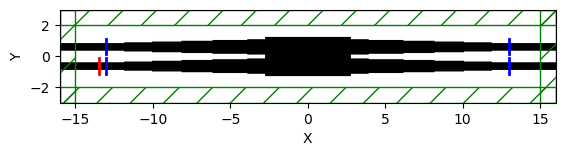

In [12]:
# Adds mode monitors at each of the ports to track the energy that goes in or out

mode_monitor_1 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=port1))
mode_monitor_2 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=port2))
mode_monitor_3 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=port3))
mode_monitor_4 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=port4))

# Plot the simulation
plot_plane = mp.Volume(center=mp.Vector3(z=0), size=mp.Vector3(cell.x, cell.y, 0))
sim.plot2D(output_plane=plot_plane if sim_is_3D else None) # No parameters are needed for a 2D simulation. 


As we see from the output of sim.plot2D, our simulation is set up correctly. The red line is our source, the blue are our 4 monitors. We are ready to run the simulation! Actually running the simulation is the most computationally intense part of this, so it may take some time if you have a high resolution and are running a 3D simulation. The `until_after_sources=mp.stop_when_dft_decayed` parameter for sim.run() means meep will start checking how much the cumulative Fourier Transform of all the fields in the simulation changes only after the sources have turned off. Then, it will wait until the DFT's change over one time step is below a certain threshold (1e-11 relative change by default), at which point it will stop the simulation

In [ ]:
# Runs the simulation
sim.run(until_after_sources=mp.stop_when_dft_decayed)

Now that our simulation has been run, the monitors contain the s-parameters which we can retrieve. The function sim.get_eigenmode_coefficients() returns an array that holds the parameters for every mode, every frequency, and in the forward and backward direction. In our simulation we only simulated the fundamental TE mode and at only our center frequency. For most applications, only the fundamental TE mode matters, but often we do want to see how the S-parameters change with frequency. To do that, simply change the df and nfreq parameters for the mode monitors. However, in our simulation we do care about the direction. In our simulation, light will go in port 1 going forward (towards positive X) and exit ports 3 and 4 in the same direction, but any light exiting port 1 and 2 will be going backwards (towards negative X). Therefore, we retrieve the index [0,0,1] for port 1 and 2 which is the index for backward propagating mode.

In [ ]:
# Finds the S parameters
norm_mode_coeff = sim.get_eigenmode_coefficients(mode_monitor_1, [1], eig_parity=mode_parity).alpha[0, 0, 0]
port1_coeff = sim.get_eigenmode_coefficients(mode_monitor_1, [1], eig_parity=mode_parity).alpha[0, 0, 1] / norm_mode_coeff
port2_coeff = sim.get_eigenmode_coefficients(mode_monitor_2, [1], eig_parity=mode_parity).alpha[0, 0, 1] / norm_mode_coeff
port3_coeff = sim.get_eigenmode_coefficients(mode_monitor_3, [1], eig_parity=mode_parity).alpha[0, 0, 0] / norm_mode_coeff
port4_coeff = sim.get_eigenmode_coefficients(mode_monitor_4, [1], eig_parity=mode_parity).alpha[0, 0, 0] / norm_mode_coeff
# Store the S parameters in s_params
s_params[0] = [port1_coeff, port2_coeff, port3_coeff, port4_coeff]


# Prints out the S parameters
print("\n-----------------------------------------------------------------\n")
print(f"Normalized s-params:\nPort1(Lower Left, S11): {np.abs(port1_coeff):.6f}, {np.angle(port1_coeff)} deg  \nPort2(Upper Left, S12): {np.abs(port2_coeff):.6f}, {np.angle(port2_coeff)} deg  \nPort3(Upper Right, S13): {np.abs(port3_coeff):.6f}, {np.angle(port3_coeff)} deg  \nPort4(Lower Right, S14): {np.abs(port4_coeff):.6f}, {np.angle(port4_coeff)} deg")
print("\n-----------------------------------------------------------------\n")



Just for fun, we'll also compute and print the transmittance through each port and the total insertion loss. We won't do this with the other ports as inputs, but it's a good exercise here. 

In [ ]:
# Calculates the transmittance based off of the S parameters
port1_trans = abs(port1_coeff) ** 2 / abs(input_coeff) ** 2
port2_trans = abs(port2_coeff) ** 2 / abs(input_coeff) ** 2
port3_trans = abs(port3_coeff) ** 2 / abs(input_coeff) ** 2
port4_trans = abs(port4_coeff) ** 2 / abs(input_coeff) ** 2

# Calculates the Insertion loss as a percent and in dB
insertionLoss = 1-(port2_trans + port3_trans + port4_trans)
insertionLoss_dB = 10*np.log10(insertionLoss) 

# Prints the Transmittance
print("\n-----------------------------------------------------------------\n")
print("Transmittance/Reflectance: Port1: {:.6f}% Port2: {:.6f}%, Port3: {:.6f}%, Port4: {:.6f}%".format(port1_trans*100, port2_trans*100, port3_trans*100, port4_trans*100))
print("Insertion Loss: {:.6f}% -> {:.6f}db".format(insertionLoss*100, insertionLoss_dB))
print("\n-----------------------------------------------------------------\n")



We find that this component is actually terrible and would never be used in an actual photonic design. Almost a third of the light is lost, and the light that isn't lost is not split in any specific ratio. Fortunately, it was never meant to be used, and just exists as an example of the basic shape of an mmi.

Finally, before we move on to the next step, we'll run the simulation again and create a plot of the steady state of the mmi. 

In [ ]:
# Reset the simulation in order to run it again and visulaize the fields
sim.reset_meep()

# Create a continuous source
sources = [
    mp.EigenModeSource(
        src=mp.ContinuousSource(fcen, fwidth=df),
        size=port1.size,
        center=port1.center,
        eig_band=1,
        eig_parity=mp.EVEN_Y + mp.ODD_Z,
        eig_match_freq=True,
    )
]

# Sets up the simulation again
sim = mp.Simulation(
    resolution=res,
    cell_size=cell.size,
    boundary_layers=[mp.PML(dpml)],
    sources=sources,
    geometry=geometry,
)

# Runs the simulation for a long time to ensure that the fields have reached a steady state
sim.run(
    until=300
)

# Gets data
eps_data = sim.get_epsilon() # Epsilon Data / The Geometry / An array that holds what materials are where
ez_data = np.real(sim.get_efield_z()) # Values for the component of the E-field in the z direction (in/out of screen)

# Creates the plot
plt.figure(dpi=200)
plt.imshow(np.transpose(eps_data), interpolation="spline36", cmap="binary")
plt.imshow(
    np.flipud(np.transpose(ez_data)),
    interpolation="spline36",
    cmap="RdBu",
    alpha=0.9,
)
plt.axis("off")
plt.show()

### Step 3: Run the same simulation for each of the other ports

Now, all that's left to do is to run the simulation for each source. Here, I'll use a for loop to run the other three simulations. We could have done this for all four, but hopefully this makes the code make more sense. 

For the sources going into port 3 and 4, we have to specify that the light will be propagating backwards. Below, I've done this by setting the direction to mp.NO_DIRECTION and using the eig_kpoint parameter to specify the direction. You can use this same method to launch sources in any direction. 

It should be noted, that since the 2x2 mmi we are using is symmetrical across both the x and y axies, the S-parameters should be the same for all of the other ports. But for the sake of demonstration, we'll simulate all of them. Then at then end we can check to see the the S-parameters are actually the same. 

In [ ]:

# Set up the rest of the sources for the simulation.
sources = [
    mp.EigenModeSource(
            src = mp.GaussianSource(fcen, fwidth=df),
            size=port2.size, # Here we input the geometry for our first source
            center=port2.center,
            eig_band=1,
            eig_parity = mp.NO_PARITY if sim_is_3D else mp.EVEN_Y + mp.ODD_Z,
            eig_match_freq = True,

    ),
    mp.EigenModeSource(
            src = mp.GaussianSource(fcen, fwidth=df),
            size=port3.size, # Here we input the geometry for our first source
            center=port3.center,
            eig_band=1,
            eig_parity = mp.NO_PARITY if sim_is_3D else mp.EVEN_Y + mp.ODD_Z,
            eig_match_freq = True,
            eig_kpoint = mp.Vector3(-1,0,0),
            direction = mp.NO_DIRECTION

    ),
    mp.EigenModeSource(
            src = mp.GaussianSource(fcen, fwidth=df),
            size=port4.size, # Here we input the geometry for our first source
            center=port4.center,
            eig_band=1,
            eig_parity = mp.NO_PARITY if sim_is_3D else mp.EVEN_Y + mp.ODD_Z,
            eig_match_freq = True,
            eig_kpoint = mp.Vector3(-1,0,0),
            direction = mp.NO_DIRECTION

    )
]

In [ ]:


for i in range(n_ports-1) :

    source = sources[i:i+1]

    sim.reset_meep() # resets everything

    # Create Simulation
    sim = mp.Simulation(
    resolution=res, # The resolution, defined further up
    cell_size=cell.size, # The cell size, taken from the gds
    boundary_layers=[mp.PML(dpml)], # the perfectly matched layers, with a diameter as defined above
    sources = source, # The source(s) we just defined
    geometry = geometry # The geometry, from above
    )
    
    # Adds mode monitors at each of the ports to track the energy that goes in or out
    mode_monitors = []
    mode_monitors.append(sim.add_mode_monitor(fcen, 0,1, mp.ModeRegion(volume=port1)))
    mode_monitors.append(sim.add_mode_monitor(fcen, 0,1, mp.ModeRegion(volume=port2)))
    mode_monitors.append(sim.add_mode_monitor(fcen, 0,1, mp.ModeRegion(volume=port3)))
    mode_monitors.append(sim.add_mode_monitor(fcen, 0,1, mp.ModeRegion(volume=port4)))

    # Runs the simulation
    sim.run(until_after_sources=100)

    #############################################################
    # Finds the S parameters
    port1_coeff = sim.get_eigenmode_coefficients(mode_monitors[0], [1], eig_parity=mp.NO_PARITY if sim_is_3D else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, alphas[i+1][0]]
    port2_coeff = sim.get_eigenmode_coefficients(mode_monitors[1], [1], eig_parity=mp.NO_PARITY if sim_is_3D else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, alphas[i+1][1]]
    port3_coeff = sim.get_eigenmode_coefficients(mode_monitors[2], [1], eig_parity=mp.NO_PARITY if sim_is_3D else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, alphas[i+1][2]]
    port4_coeff = sim.get_eigenmode_coefficients(mode_monitors[3], [1], eig_parity=mp.NO_PARITY if sim_is_3D else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, alphas[i+1][3]]
    input_coeff = sim.get_eigenmode_coefficients(mode_monitors[i+1], [1], eig_parity=mp.NO_PARITY if sim_is_3D else mp.EVEN_Y + mp.ODD_Z).alpha[0, 0, alphas[i+1][4]] # This is the total amount of light that entered the devie

    # Store the S parameters in s_params
    index = 1+i 
    s_params[index] = [port1_coeff, port2_coeff, port3_coeff, port4_coeff]
    input_params[index] = input_coeff

In [ ]:
print("S-Params:")
for i in range(n_ports):
    print(f"S{i+1}1: {s_params[i][0]}\tS{i+1}2: {s_params[i][1]}\tS{i+1}3: {s_params[i][2]}\tS{i+1}4: {s_params[i][3]}")

print("Input S-Params")
print(f"S1: {input_params[0]}\tS2: {input_params[1]}\tS3: {input_params[2]}\tS4: {input_params[3]}")



print("Transmission:")
for i in range(n_ports):
    input_power = abs(input_params[i])**2
    trans1 = abs(s_params[i][0])**2 / input_power * 100
    trans2 = abs(s_params[i][1])**2 / input_power * 100
    trans3 = abs(s_params[i][2])**2 / input_power * 100
    trans4 = abs(s_params[i][3])**2 / input_power * 100
    print("{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}".format(trans1, trans2, trans3, trans4))




Above, we can see all of the S-parameters from the simulations, and we can verify that the S-parameters are in fact the same for every port, which is what we expected. We also calculated the transmission which is also the same no matter what port we use. 

### S-Parameters across different Frequencies

For most applications, you'll want to know the S-parameters across a range of frequencies. This can be done using the simulations created here. When we get the S-parameters using the sim.get_eigenmode_coefficients().alpha[] we get a matrix. The first entry in the matrix specifies the wavelength. For brevities sake, we won't show that here, but a good exercise would be to find and plot the s-paramters across a range of frequencies for the component shown here. 

## Import the generated s-matrix to be used in simphony

## References

[MathWorks: What are S-Parameters](https://www.mathworks.com/discovery/s-parameter.html)

[Luceda: Scatter matrix](https://docs.lucedaphotonics.com/guides/caphe_models_frequency/scatter_matrix)

[Microwaves101: S-Parameters](https://www.microwaves101.com/encyclopedias/s-parameters)

[Youtube: Understanding S-Parameters](https://www.youtube.com/watch?v=-Pi0UbErHTY)



